# Library Imports and Data Processing

In [ ]:
!pip install wandb -q

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn
import wandb
from wandb.keras import WandbCallback
from PIL import Image
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\0730\AppData\Local\Temp\ipykernel_8560\3698179942.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
os.environ['KAGGLE_CONFIG_DIR'] = "Fish_Dataset"
# plt.style.use("seaborn-darkgrid")
sns.set_context("paper", font_scale=1.4)

In [3]:
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
RANDOM_STATE = 42
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
METRICS = [
    "accuracy",
    "precision",
    "recall"
]

# Helper Functions

In [4]:
def get_dataset():
  main_directory = r"Fish_Dataset\Fish_Dataset"
  images = []
  labels = []
  for directory in tqdm(os.listdir(main_directory)):
      next_directory = f"{main_directory}/{directory}"
      if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
        continue
      for images_directory in os.listdir(next_directory):
          if "GT" not in images_directory:
              final_directory = f"{next_directory}/{images_directory}"
              for image in os.listdir(final_directory):
                  images.append(np.array(Image.open(f"{final_directory}/{image}").resize((224, 224))))
                  labels.append(images_directory)
  images = np.array(images)
  labels = np.array(labels)
  return images, labels


def plot_training_images(images, labels):
  plot_images = []
  plot_labels = []
  for i, j in zip(images, labels):
    if j in plot_labels:
      continue
    else:
      plot_images.append(i)
      plot_labels.append(j)
  fig, axes = plt.subplots(nrows = 3, ncols = 3, sharex=False, figsize=(12, 12))
  for i in range(3):
    for j in range(3):
      axes[i][j].imshow(plot_images[i * 3 + j])
      axes[i][j].set_xlabel(plot_labels[i * 3 + j])
      axes[i][j].set_xticks([])
      axes[i][j].set_yticks([])
  plt.tight_layout()
  plt.show()

def get_tf_dataset(images, labels):
    return tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE).prefetch(1)


# def get_tf_dataset(images, labels):
#  return tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE).prefetch(1)


def split_dataset(images, labels, test_size = 0.2, valid_size = 0.2):
  train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = test_size, random_state = RANDOM_STATE)
  train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size = valid_size, random_state = RANDOM_STATE)
  return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)


def plot_cm(test_labels, prediction_labels, encoder):
  plt.figure(figsize=(15, 15))
  cm = confusion_matrix(test_labels, prediction_labels)
  df_cm = pd.DataFrame(cm, index = [i for i in encoder.categories_[0]],
                    columns = [i for i in encoder.categories_[0]])
  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
  plt.show()


def plot_history(history):
  fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 10))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[0][1])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["precision"], ax = axes[1][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["recall"], ax = axes[1][1])
  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[0][1])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_precision"], ax = axes[1][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_recall"], ax = axes[1][1])
  
  axes[0][0].set_title("Loss Comparison", fontdict = {'fontsize': 20})
  axes[0][0].set_xlabel("Epoch")
  axes[0][0].set_ylabel("Loss")

  axes[0][1].set_title("Accuracy Comparison", fontdict = {'fontsize': 20})
  axes[0][1].set_xlabel("Epoch")
  axes[0][1].set_ylabel("Accuracy")

  axes[1][0].set_title("Precision Comparison", fontdict = {'fontsize': 20})
  axes[1][0].set_xlabel("Epoch")
  axes[1][0].set_ylabel("Precision")

  axes[1][1].set_title("Recall Comparison", fontdict = {'fontsize': 20})
  axes[1][1].set_xlabel("Epoch")
  axes[1][1].set_ylabel("Recall")
  plt.tight_layout()
  plt.show()


def get_resnet(categories):
  conv_block = tf.keras.applications.resnet.ResNet50(include_top = False, weights = "imagenet")
  output = tf.keras.layers.GlobalAveragePooling2D()(conv_block.output)
  output = tf.keras.layers.Dense(categories, activation = "softmax")(output)
  model = tf.keras.Model(inputs = [conv_block.input], outputs = [output])
  return model, "ResNet50"

# Dataset Preprocessing

In [5]:
RANDOM_STATE = 42
images, labels = get_dataset()
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = split_dataset(images, labels)


100%|██████████| 12/12 [02:56<00:00, 14.68s/it]


In [6]:
encoder = OneHotEncoder(sparse_output=False)
train_labels = encoder.fit_transform(train_labels.reshape(-1, 1))
valid_labels = encoder.transform(valid_labels.reshape(-1, 1))
test_labels = encoder.transform(test_labels.reshape(-1, 1))
train_dataset = get_tf_dataset(train_images, train_labels)
valid_dataset = get_tf_dataset(valid_images, valid_labels)

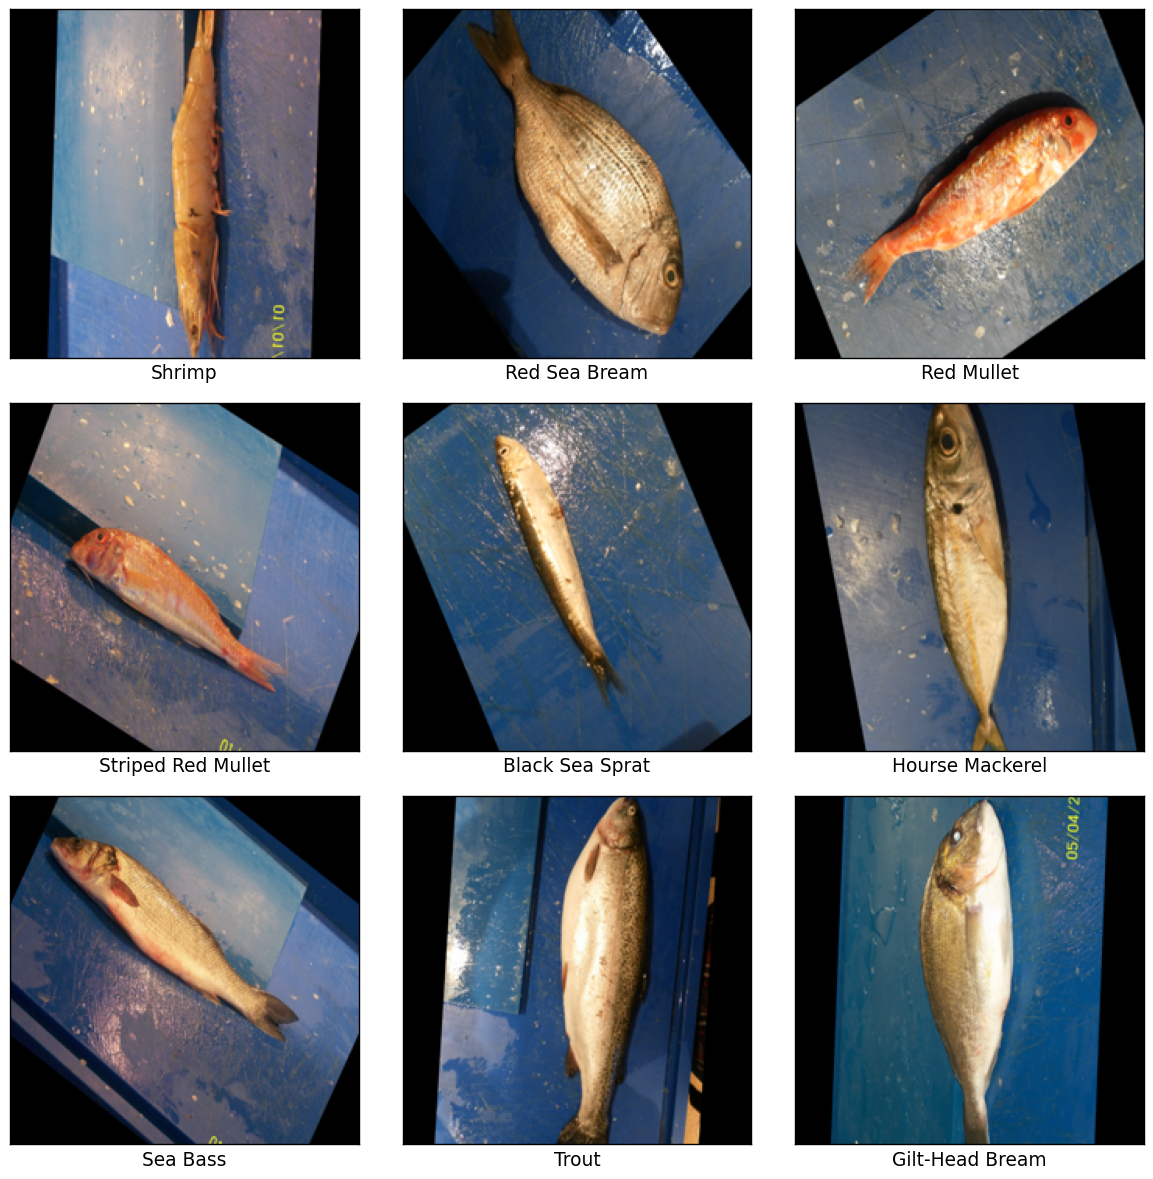

In [7]:
plot_training_images(train_images, encoder.inverse_transform(train_labels).reshape(-1,))

# ResNet50

In [8]:
def get_resnet(categories):
  conv_block = tf.keras.applications.resnet.ResNet50(include_top = False, weights = "imagenet")
  output = tf.keras.layers.GlobalAveragePooling2D()(conv_block.output)
  output = tf.keras.layers.Dense(categories, activation = "softmax")(output)
  model = tf.keras.Model(inputs = [conv_block.input], outputs = [output])
  return model, "ResNet50"

In [9]:
'''

model, model_name = get_resnet(len(encoder.categories_[0]))
config_defaults = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "model_name": model_name,
  "loss": LOSS,
  "random_state": RANDOM_STATE,
  "optimizer": OPTIMIZER,
  "metrics": METRICS
}
wandb.init(project="Fish_Dataset_Classification", id="resnet50", config = config_defaults)
model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_dataset,
                    validation_data = valid_dataset, 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights = True), WandbCallback(save_model=False, save_graph=False)])
'''

'\n\nmodel, model_name = get_resnet(len(encoder.categories_[0]))\nconfig_defaults = {\n  "learning_rate": LEARNING_RATE,\n  "epochs": EPOCHS,\n  "batch_size": BATCH_SIZE,\n  "model_name": model_name,\n  "loss": LOSS,\n  "random_state": RANDOM_STATE,\n  "optimizer": OPTIMIZER,\n  "metrics": METRICS\n}\nwandb.init(project="Fish_Dataset_Classification", id="resnet50", config = config_defaults)\nmodel.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])\n\nhistory = model.fit(train_dataset,\n                    validation_data = valid_dataset, \n                    batch_size = BATCH_SIZE,\n                    epochs = EPOCHS, \n                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights = True), WandbCallback(save_model=False, save_graph=False)])\n'

In [10]:
import tensorflow as tf

# Define your get_resnet function
def get_resnet(categories):
    conv_block = tf.keras.applications.resnet.ResNet50(include_top=False, weights="imagenet")
    output = tf.keras.layers.GlobalAveragePooling2D()(conv_block.output)
    output = tf.keras.layers.Dense(categories, activation="softmax")(output)
    model = tf.keras.Model(inputs=[conv_block.input], outputs=[output])
    return model, "ResNet50"

# Define your config defaults
LEARNING_RATE = 0.001  # Replace with your desired learning rate
EPOCHS = 10  # Replace with your desired number of epochs
BATCH_SIZE = 32  # Replace with your desired batch size
LOSS = 'categorical_crossentropy'  # Replace with your desired loss function
RANDOM_STATE = 42  # Replace with your desired random state
OPTIMIZER = 'adam'  # Replace with your desired optimizer
METRICS = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

model, model_name = get_resnet(len(encoder.categories_[0]))

# Compile the model
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

# Fit the model
# model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data)


In [11]:
# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping_callback])

Epoch 1/10


180/180 [==============================] - 1383s 7s/step - loss: 0.4362 - accuracy: 0.8741 - precision: 0.9149 - recall: 0.8340 - val_loss: 2.7928 - val_accuracy: 0.5972 - val_precision: 0.6067 - val_recall: 0.5882
Epoch 2/10
180/180 [==============================] - 2902s 16s/step - loss: 0.0664 - accuracy: 0.9802 - precision: 0.9824 - recall: 0.9780 - val_loss: 1.7430 - val_accuracy: 0.7271 - val_precision: 0.7374 - val_recall: 0.7215
Epoch 3/10
180/180 [==============================] - 4421s 25s/step - loss: 0.0582 - accuracy: 0.9809 - precision: 0.9831 - recall: 0.9778 - val_loss: 0.2109 - val_accuracy: 0.9257 - val_precision: 0.9357 - val_recall: 0.9194
Epoch 4/10
180/180 [==============================] - 1314s 7s/step - loss: 0.0085 - accuracy: 0.9972 - precision: 0.9976 - recall: 0.9972 - val_loss: 0.0244 - val_accuracy: 0.9903 - val_precision: 0.9917 - val_recall: 0.9903
Epoch 5/10
180/180 [==============================] - 10262s 57s/step - loss: 6.2011e-04 - a

In [12]:
result_inter = model.predict(test_images)
prediction_index = np.argmax(result_inter, axis = -1)
result = np.zeros(shape = test_labels.shape, dtype = test_labels.dtype)
for i in range(result.shape[0]):
  result[i][prediction_index[i]] = 1.0

57/57 [==============================] - 204s 3s/step


In [13]:
test_labels = encoder.inverse_transform(test_labels)
prediction_labels = encoder.inverse_transform(result)

In [14]:
print(classification_report(test_labels, prediction_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       195
   Gilt-Head Bream       1.00      1.00      1.00       211
   Hourse Mackerel       1.00      1.00      1.00       179
        Red Mullet       1.00      1.00      1.00       191
     Red Sea Bream       1.00      1.00      1.00       203
          Sea Bass       1.00      1.00      1.00       207
            Shrimp       1.00      1.00      1.00       209
Striped Red Mullet       1.00      1.00      1.00       204
             Trout       1.00      1.00      1.00       201

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



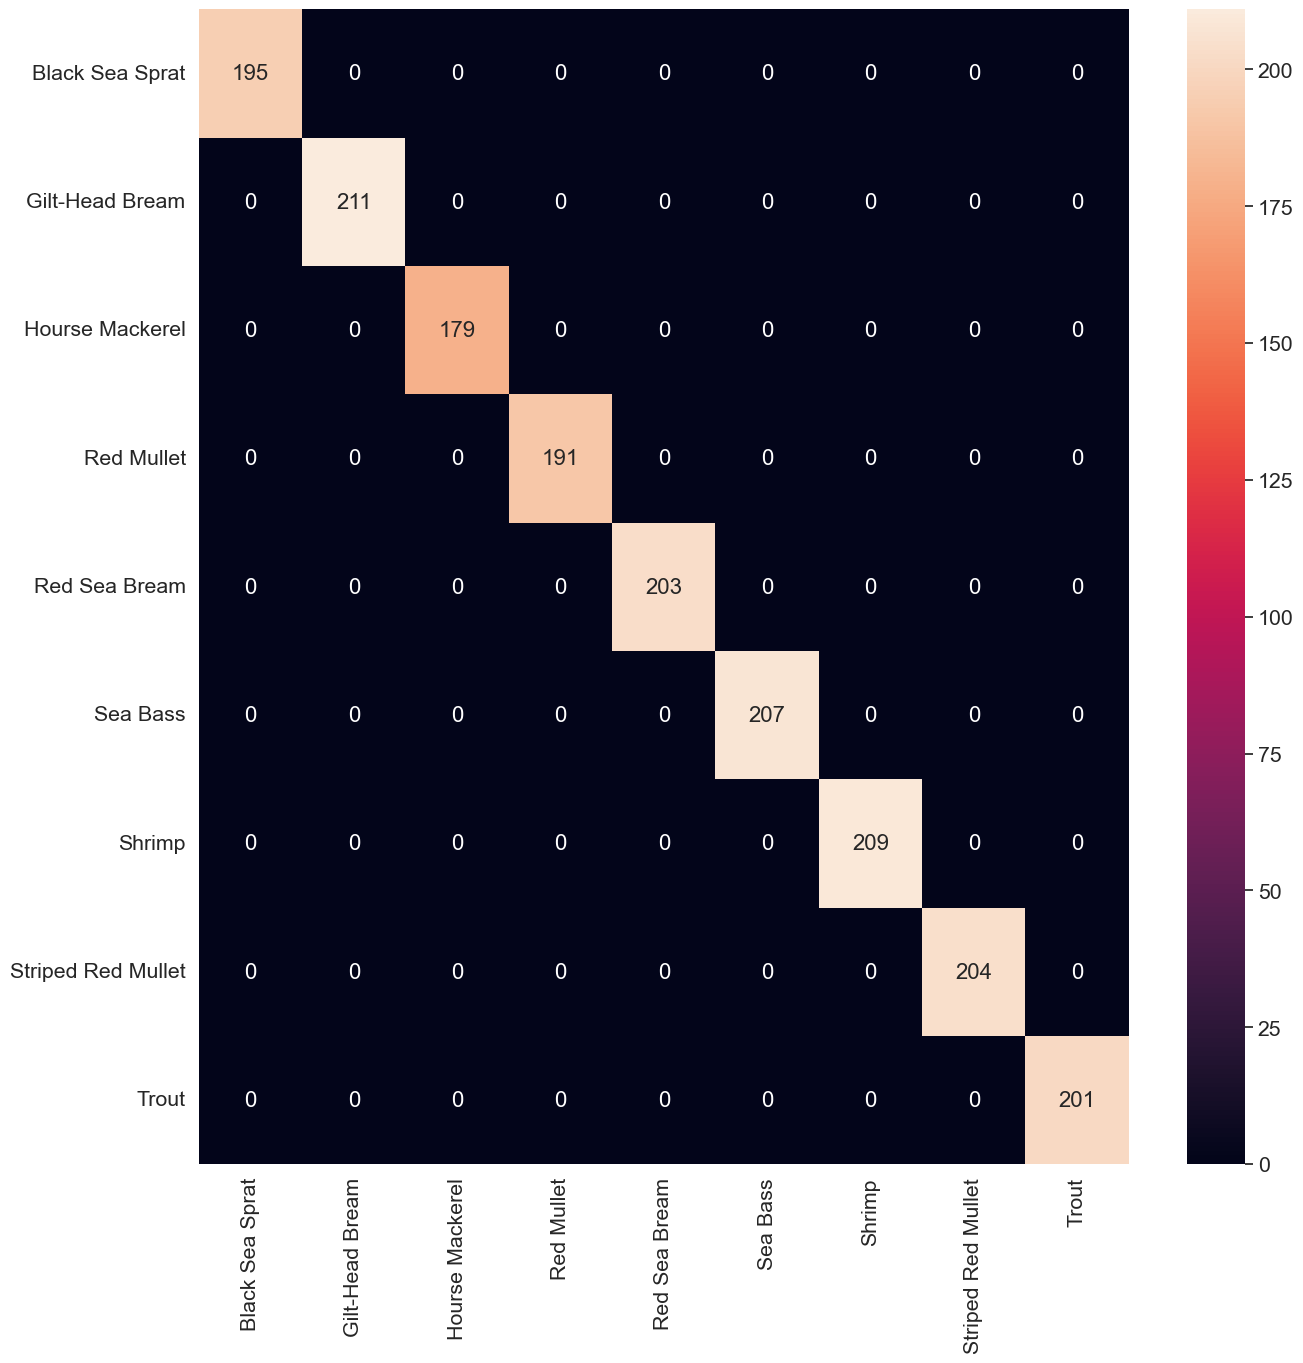

In [15]:
plot_cm(test_labels, prediction_labels, encoder)

In [17]:
model.save("resnet.h5")